# Clustermethode: Poisson 🐟

Dit model deelt de lijn op in een aantal bakjes (elke **4 meter**), en accumeleert dan alle PDs per bakje. Hierbij kan PD-lading **wel of niet** worden meegenomen. (Een mogelijk verbeterpunt is dat de tijd ook wordt opgesplitst in een aantal delen.) Vervolgens wordt aangenomen dat **ten minste 80% van de kabel** nominaal PD-gedrag vertoont. 

De 80% van de bakjes met het laagste aantal PDs wordt gebruikt om een Poisson-verdeling te fitten voor nominaal PD-gedrag. (Hierbij wordt rekening gehouden met het feit dat alleen de 80% kleinste realisaties bekend zijn.)

Vervolgens wordt de volledige lijn weer beschouwd. Alle bakjes waarin het aantal PDs een onwaarschijnlijkheid heeft van **minimaal 5%**, _gegeven de gevonden verdeling voor nominaal PD-gedrag_, wordt als een zeer verdacht hokje beschouwd.

Ten slotte worden alle aangrenzende, zeer verdachte hokjes samengenomen tot een _cluster_. Twee clusters die **maximaal 2** hokjes uit elkaar liggen, worden als één cluster beschouwd. Er geldt ook beperking dat een cluster  **minimaal 3** verdachte hokjes moet bevatten, zoniet wordt het cluster genegeerd.

---------

## Parameters
De vijf **dikgedrukte** getallen zijn parameters die aangepast kunnen worden. De huidige keuze identificeert de gewenste resultaten. Wanneer er geen clusters zijn, wordt dit correct herkend.

Het aantal parameters lijkt hoog, maar dit zorgt er juist voor dat dezelfde parameters op alle circuits goed werken.

----------

## Snelheid

Zonder parallelisatie, op een Intel i5. Hierbij wordt het inladen (en plotten) van een dataset niet meegeteld.

**Circuit 2145 (hoogste aantal PDs)**

| Routine                                    | Tijd (`%%timeit`)    |
| ------------------------------------------ | -------------------- |
| Discretiseren; PDs tellen                  | 3.72 ms ± 88.5 µs    |
| 80% kwantiel bepalen                       | 9.51 µs ± 604 ns     |
| Poisson-verdeling fitten                   | 108 µs ± 3.21 µs     |
| 95% kwantiel van Poisson-verdeling bepalen | 105 µs ± 6.75 µs     |
| Zeer verdachte hokjes identificeren        | 2.72 µs ± 43.8 ns    |
| Clusteren van Boolean reeks                | 84.4 µs ± 4.86 µs    |
| **Totaal**                                 | **4.03 ms ± 100 µs** |

De duidelijke bottleneck is het tellen van PDs in hokjes. Hier wordt de ingebouwde functie `np.histogram` voor gebruikt, en zal waarschijnlijk dus alleen sneller kunnen door te paralleliseren.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ipywidgets
from IPython.display import display, clear_output, Javascript, Markdown

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 4]

# Dataset laden

Eerst zoeken we de root-map van deze reposity, en vanaf daar de data-map. Door `pathlib` te gebruiken werkt deze code op elke OS, en door de root te zoeken ook vanaf elk script/notebook in de repository.

In [2]:
def subdirectories_of(path):
    return [item.resolve() for item in path.iterdir() if item.is_dir()]


current_path = Path().resolve()
git_path = current_path

# While we are not at the root of the git directory:
while not '.git' in map(lambda p: p.name, subdirectories_of(git_path)):
    # Move one directory up, and check again
    git_path = git_path.parent.resolve()
    if len(git_path.parts) <= 1:
        raise Warning("This script is not running in the git repository. Configure data path manually.")


data_path = git_path / "data" / "origineel"
print("Git root path found at: "+str(git_path))
print("Using data path:        " + str(data_path))

if not Path(data_path).is_dir():
    raise Warning("Data path does not exist")

Git root path found at: C:\dev\py\SCG-analyse
Using data path:        C:\dev\py\SCG-analyse\data\origineel


In [3]:
# Lijst van .csv-bestanden
data_file_paths = list(data_path.glob("*.csv"))

if len(data_file_paths) == 0:
    raise Warning("No .csv files found in " + str(data_path) + "; Note that data files are not stored in this repository, and must be downloaded manually.")


# Geef het circuitnummer (4 cijfers) dat in de naam van een Path staat
circuitnum_from_file_path = lambda file_path: int(file_path.name.split('-')[0])

# Drie dictionaries, met als keys de circuitnummers (int), als value de Pandas DataFrame van de .csv.
cable_config       = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'cableconfig' in fp.name}
partial_discharges = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'pd' in fp.name}
warning            = {circuitnum_from_file_path(fp): pd.read_csv(fp, sep=";") for fp in data_file_paths if 'warning' in fp.name}

# Sla de keys op van alle kabels waarvoor PD data bestaat.
circuits = list(partial_discharges)

print("Cable config loaded for circuits:", list(cable_config))
print("   PD series loaded for circuits:", list(partial_discharges))
print("Warning logs loaded for circuits:", list(warning))

Cable config loaded for circuits: [1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010]
   PD series loaded for circuits: [1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010]
Warning logs loaded for circuits: [1512, 2063, 2145, 2806, 2870]


# Analyse
We kiezen eerst een circuit uit.

In [4]:
# Standaardkeuze:
circ = circuits[0]

In [5]:
def update_fig(event):
    global circ
    if event.name == 'value':
        circ = event.new
        # Gebruik deze 'hack' om alle cellen onder de huidige opnieuw te runnen
        display(Javascript("IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,IPython.notebook.get_cells().length)"))


circuit_chooser = ipywidgets.Dropdown(options=circuits,
                                      value=circ,
                                      description='Circuit:',
                                      disabled=False)
circuit_chooser.observe(update_fig)

display(Markdown("-----------"))
display(Markdown("# Kies een circuit:"))
display(circuit_chooser)
display(Markdown("-----------"))

-----------

# Kies een circuit:

Dropdown(description='Circuit:', options=(1512, 2063, 2145, 2806, 2870, 2979, 2980, 3010), value=1512)

-----------

Sla data van dit circuit op, en laat alle tijdstippen weg waar geen PD was.

In [6]:
# Lengte van de kabel is gegeven in de cable config
cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]


pd = partial_discharges[circ]

# Sla de drie kolomnamen van PD voor het gemak op
datetimeC, locC, chargeC = pd.columns

# Lijst met bools die aangeeft of er op dat tijdstip een PD was
pd_occured = ~np.isnan(pd[locC])

# De drie kolommen; alleen op tijdstippen met PD
locations = pd[locC][pd_occured]
charges = pd[chargeC][pd_occured]
times = pd[datetimeC][pd_occured].apply(lambda date_string: datetime.datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S"))

<IPython.core.display.Javascript object>


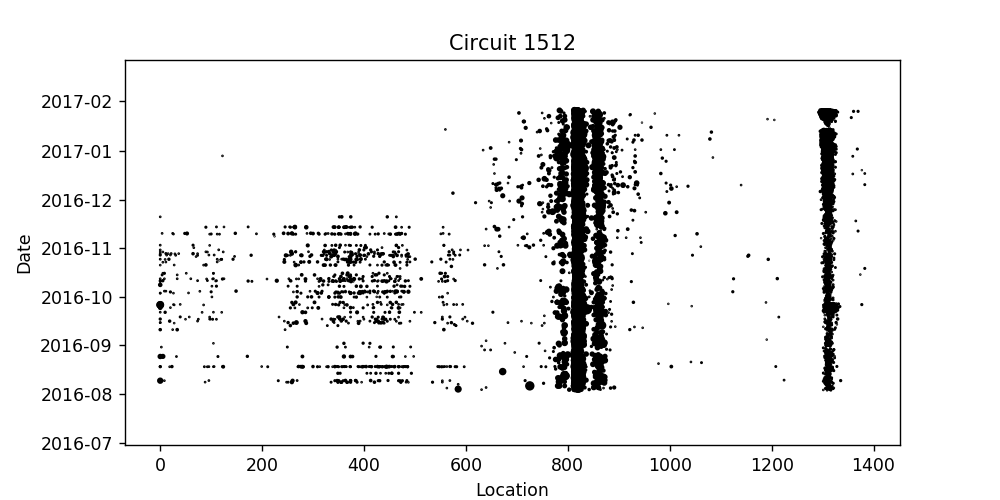

In [7]:
%matplotlib notebook

fig,ax = plt.subplots()

ax.scatter(x=locations, y=times, s=charges/1e4, c='.0')
ax.set_xlabel("Location")
ax.set_ylabel("Date")

ax.set_title("Circuit {0}".format(circ))
fig.show()

# Afstand discretiseren

In de data is afstand continu, dwz dat er (waarschijnlijk)\* geen twee PDs op precies dezelfde locatie plaatsvinden. Je kan dus nog niet praten over het 'aantal PDs op x meter'. Het lijkt dus nuttig om de afstand te discretiseren: opsplitsen in een eindig aantal 'bins', waarin elke PD-locatie valt.

\* Dit is niet helemaal waar, het aantal unieke locaties is ongeveer een tiende van het aantal PDs. Er is dus waarschijnlijk al gediscretiseerd, het lijkt elke 25cm te zijn.

In [8]:
############ PARAMETERS ############

bin_size = 4.0 # meter
count_charges = False

####################################

bins = np.arange(start=0., stop=cable_length, step=bin_size)
# Tel inhoud van elk bakje:

binned_pds, _ = np.histogram(locations, bins=bins, weights=charges if count_charges else None)

In [9]:
_="""
fig,ax = plt.subplots(2,1,figsize=(12,12))

ax1,ax2 = ax

ax1.hist(locations,bins=bins,color='0')
ax1.set_xlabel("Location (m)")
ax1.set_ylabel("Number of PDs")

ax2.hist(locations,bins=bins, weights=charges,color='0')
ax2.set_xlabel("Location (m)")
ax2.set_ylabel("Cumulative charge (pC)")

fig.show()
"""

## Aanname 1:
Met het grootste gedeelte van de lijn is niks aan de hand. We kiezen een **ondergrens voor het percentage locaties waarop niks aan de hand is**.

In [10]:
############ PARAMETER ############

lower_limit_nominal = 80.0/100.0

###################################

Sorteer de bakjes op inhoud, en beschouw de $\eta=0.8=$80% van de bakjes met de minste inhoud. De grens die we empirisch vinden noemen we $M_{\eta}$.

In [11]:
nominal_pd_level = np.sort(binned_pds)[int(lower_limit_nominal * len(binned_pds))]
nominal_pd_level

10

<IPython.core.display.Javascript object>


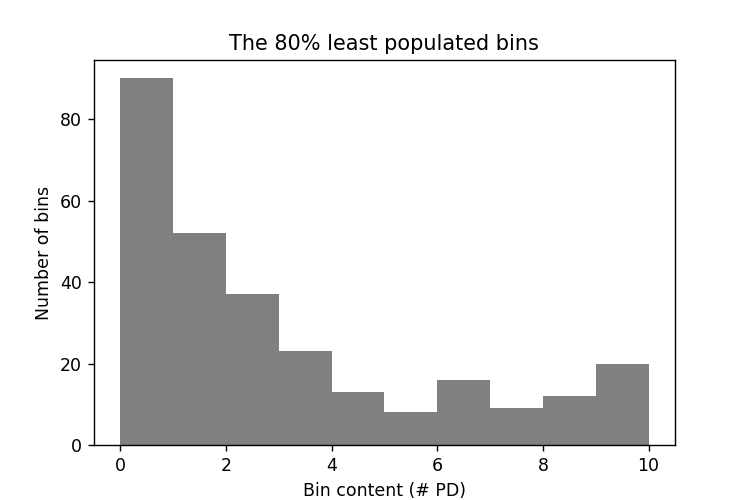

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.hist(binned_pds[binned_pds <= nominal_pd_level],color='.5')
ax.set_xlabel("Bin content " + ("(pC)" if count_charges else "(# PD)"))
ax.set_ylabel("Number of bins")
ax.set_title("The {:.0%} least populated bins".format(lower_limit_nominal))
fig.show()

Waar zit die 20%?

In [13]:
def draw_shaded_areas_on_PD_hist(ax, pd_locations, bins, shaded_at, shade_color='r', shade_alpha=.2):
    counts, _, _ = ax.hist(locations,bins=bins,color='0')
    ax.set_xlabel("Location (m)")
    ax.set_ylabel("Number of PDs")
    
    ax.fill_between(bins[:-1], 0, np.max(counts), where=shaded_at, color=shade_color, alpha=shade_alpha)


<IPython.core.display.Javascript object>


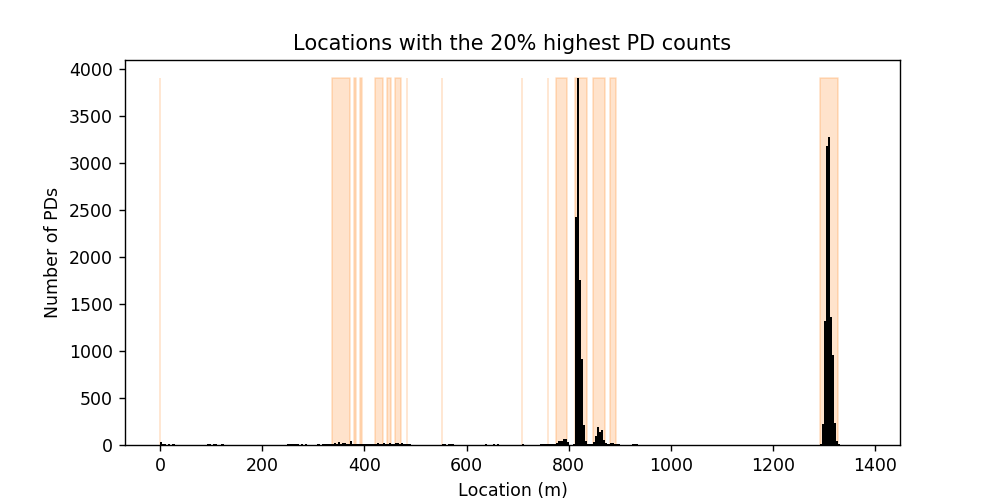

In [14]:
fig, ax = plt.subplots(1,1)

draw_shaded_areas_on_PD_hist(ax, locations, bins, binned_pds>nominal_pd_level, '#ff7700')
ax.set_title("Locations with the {:.0%} highest PD counts".format(1-lower_limit_nominal))

fig.show()

## Wilde aanname 2:
Het aantal PDs $X$ _op een nominaal stuk lijn_ is Poisson-verdeeld, $X \sim P(\lambda)$. Zó dat:

$$\mathbb{E}[X \leq M_{\eta}] = \eta.$$

(De kans dat X binnen de empirisch bepaalde 90% grens valt is exact 90%.)
Dit betekent dat als we veel samples uit deze Poisson-verdeling nemen, en we zoeken de grens van 90%, dan vinden we dezelfde $M_{\eta}$ en dan zouden we dezelfde $\lambda$ kiezen.

### Berekening $\lambda$

We kunnen de Poisson-verdling met parameter $\lambda$ schatten met een normaalverdeling $N(\mu = \lambda, \sigma^2 = \lambda)$. Stel $Y$ is zo verdeeld.

$$\mathbb{E}[Y \leq M_{\eta}] = \mathbb{E}[N(0,\lambda) \leq M_{\eta} - \lambda] = \mathbb{E}[N(0,1) \leq M_{\eta}/\sqrt{\lambda} - \sqrt{\lambda}] = \eta$$.

Dus $M_{\eta}/\sqrt{\lambda} - \sqrt{\lambda} = \Phi(\eta)$ en

$$\lambda = \frac{1}{4}\left(-\Phi(\eta) + \sqrt{\Phi(\eta)^2 + 4M_{\eta}}\right)^2.$$

($\Phi$ is de inverse van de verdelingsfunctie(?) (CDF) van de standaard normaalverdeling.)

In [15]:
square = lambda x: x*x

phieta = scipy.stats.norm.ppf(q=lower_limit_nominal)
rate = .25*square(-phieta + np.sqrt(square(phieta) + 4*nominal_pd_level))

rate

7.669261933388965

## Wilde aanname 3:
Op plekken waar een fout zit is het aantal PDs _abnormaal hoog, volgens de gevonden Poisson-verdeling_. Abnormaal = 5 op 100?

In [16]:
############ PARAMETER ############

lower_limit_fault = 95.0 / 100.0

###################################

In [17]:
if rate == 0.0:
    # rate was zero: fault_pd_level should be zero, not nan
    fault_pd_level = 0.0
else:
    # Als ik de ppf van de scipy.stats.poisson gebruik krijg ik alleen maar resultaten heel dichtbij M_{\eta}
    # dat hoort niet (toch?)
    fault_pd_level = scipy.stats.norm.ppf(q=lower_limit_fault, loc=rate, scale=rate)

fault_pd_level

20.28407524056466

<IPython.core.display.Javascript object>


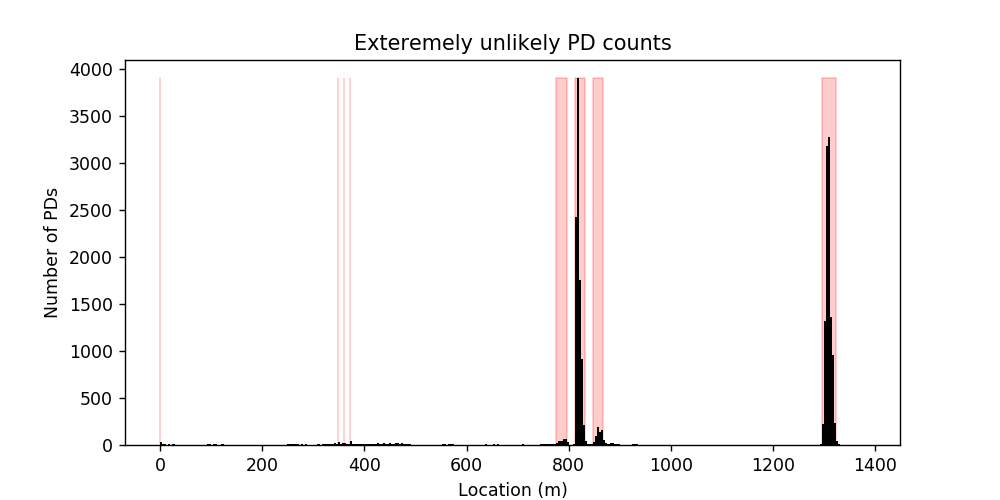

In [18]:
fig, ax = plt.subplots(1,1)

draw_shaded_areas_on_PD_hist(ax, locations, bins, binned_pds>fault_pd_level, 'r')
ax.set_title("Exteremely unlikely PD counts")

fig.show()

# Een simpel clusteralgortime

We hebben nu een deelverzameling $W$ van de locaties van de bakjes, waarop het aantal PDs met zekerheid abnormaal hoog is. Het is te zien dat bij pieken hier een rij opeenvolgende getallen in staat, maar soms mist er eentje.

We definieren een cluster dmv twee parameters:
* Een 'gat' in het cluster is maximaal $n_{skip} \in \mathbb{N}$ groot.
* Het cluster heeft minimaal $m_{min} \in \mathbb{N}$ elementen.



In [19]:
############ PARAMETERS ############

max_skip = 2
min_count = 3

####################################

In [20]:
def cluster_boolean_series(series, max_consecutive_false=5, min_length=5, min_count=0):
    """
    Imperative algorithm to identify sequences of mostly True values, under the conditions imposed by the parameters:
    
    Parameters
    ----------
    
    series : array_like
        Sequence of Booleans to cluster
    
    max_consecutive_false : int
        Maximum number of consecutive Falsey values to accept inside a cluster
    
    min_length : int
        Minimum cluster length (right bound - left bound)
    
    min_count : int
        Minimum cluster size (number of Truthy values inside cluster bounds)
    """
    
    clusters = set()
    
    
    cluster_start = 0   # Beginindex van het huidige cluster
    gap_size = 0        # Lengte van de rij nee'tjes die nu wordt belopen
    true_count = 0      # Aantal ja'tjes dat is gevonden in dit cluster
    
    for i, x in enumerate(series):
        if x:  # We doorlopen ja'tjes
            true_count += 1
            if gap_size > max_consecutive_false:   # Einde cluster
                cluster_end = i - gap_size
                if cluster_end - cluster_start >= min_length and true_count >= min_count:
                    # Cluster was lang genoeg en heeft genoeg ja'tjes:
                    clusters.add((cluster_start, cluster_end))
                
                # Begin een nieuw cluster
                cluster_start = i
                true_count = 0
            
            gap_size = 0  # We doorlopen geen nee'tjes (meer)
        
        if not x:  # We doorlopen nee'tjes
            gap_size += 1
    
    cluster_end = len(series) - gap_size
    if cluster_end - cluster_start >= min_length and true_count >= min_count:
        # Cluster was lang genoeg en heeft genoeg ja'tjes:
        clusters.add((cluster_start, cluster_end))
    return clusters

Testjes algoritme:

In [21]:
print(cluster_boolean_series(np.array([1,1,1,0, 0, 1]) >= 1, max_consecutive_false=1, min_length=1))
print(cluster_boolean_series(np.array([1,0,1,0, 0, 1]) >= 1, max_consecutive_false=1, min_length=1))
print(cluster_boolean_series(np.array([1,0,1,0, 0, 1]) >= 1, max_consecutive_false=2, min_length=1))

{(5, 6), (0, 3)}
{(5, 6), (0, 3)}
{(0, 6)}


Op onze data:

In [22]:
min_length = 0

clusters = cluster_boolean_series(binned_pds > fault_pd_level, max_skip, min_length, min_count)
clusters

{(87, 94), (194, 200), (203, 209), (212, 218), (324, 332)}

<IPython.core.display.Javascript object>


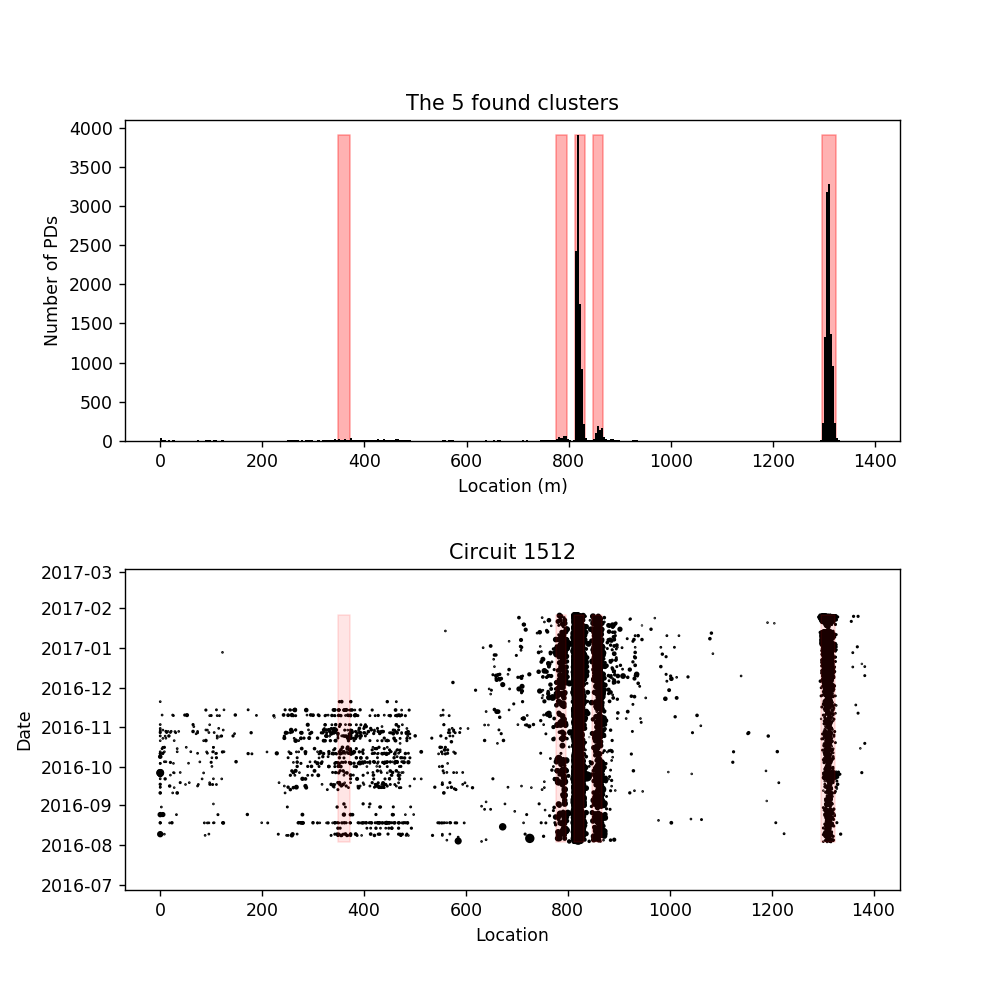

In [27]:
def inside_a_cluster(location):
    bin_index = int(location/bin_size)
    return any(a <= bin_index < b for a,b in clusters)

inside_a_cluster_v = np.vectorize(inside_a_cluster)


fig,ax = plt.subplots(2,1,figsize=(8,8))

ax1,ax2 = ax

draw_shaded_areas_on_PD_hist(ax1, locations, bins, inside_a_cluster_v(bins[:-1]), 'r', .3)
ax1.set_title("The {0} found clusters".format(len(clusters)))

ax2.scatter(x=locations, y=times, s=charges/1e4, c='.0')
ax2.set_xlabel("Location")
ax2.set_ylabel("Date")
ax2.set_title("Circuit {0}".format(circ))
ax2.fill_between(bins[:-1], np.min(times), np.max(times), where=inside_a_cluster_v(bins[:-1]), color='r', alpha=.1)

fig.subplots_adjust(hspace=.4)
fig.show()

# Conclusie

Het werkt goed!
Door eerst de 80% marge te zoeken, en dan de onderste 80% te gebruiken om een verdeling te fitten, kan de ruis _gebruikt worden om te bepalen hoe bijzonder de uitschieters zijn_. Hierdoor vindt het bijvoorbeeld 0 clusters in de laatste sets (wat de bedoeling is).

In het tweede circuit wordt een cluster niet gevonden. Ik denk dat dit is omdat dat cluster maar korte duur had, en daarom in de lange dataset minder opvalt. (Er wordt namelijk gesommeerd over de volledige tijdreeks.) Dit kan overkomen worden door het algoritme los toe te passen op elke maand, bijvoorbeeld.